In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adatae=sc.read('../scRNA_paga/state_adata/Quartzseq_equilibrate.h5ad')
adatam=sc.read('../scRNA_paga/state_adata/Quartzseq_minimize.h5ad')


# Linear Flat Model

In [3]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']
resol=[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-100]

In [7]:
flat=dict()
for res in range(len(resol)):
    M=adatae.uns['nsbm']['cell_affinity']['2']
    adatae.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatae[adatae.obs.max_u < resol[res]]
    adata=ciao3.copy()
    marginals = adata.uns['nsbm']['cell_affinity']['2'] 
    groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    gene_names = []
    gene_scores = []
    gene_pvalues = []
    gene_fdr = []
    gene_foldchange = []
    for x in range(flat_scores.shape[1]):
        up_mask = flat_scores[:, x] > 0
        scores = flat_scores[up_mask, x]
        pvals = flat_pvals[up_mask, x]
        genes = np.array(adatam.var_names)[up_mask]
        fdr = flat_fdr[up_mask, x]
        selected = np.argsort(fdr)
        order = np.argsort(scores[selected])[::-1]
        gene_names.append(genes[selected][order])
        gene_scores.append(scores[selected][order])
        gene_pvalues.append(pvals[selected][order])
        gene_fdr.append(fdr[selected][order])
        gene_foldchange.append(scores[selected][order])
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for f in range(len(adata.obs.nsbm_level_2.cat.categories)):
        e[adata.obs.nsbm_level_2.cat.categories[f]]=e.get(adata.obs.nsbm_level_2.cat.categories[f],{})
        count=0
        for s in adata.obs.nsbm_level_2:
            if s==adata.obs.nsbm_level_2.cat.categories[f]:
                count=count+1
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_obs']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_obs', count)
        sel_p=[]
        sel_g=[]
        for g in range(len(gene_fdr[f])):
            if gene_fdr[f][g]<0.05:
                sel_p.append(gene_fdr[int(f)][g])
                sel_g.append(gene_names[int(f)][g])
        e[adata.obs.nsbm_level_2.cat.categories[f]]['n_significative']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('n_significative', len(sel_g))
        e[adata.obs.nsbm_level_2.cat.categories[f]]['gene_names']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('gene_names', sel_g)
        e[adata.obs.nsbm_level_2.cat.categories[f]]['pvals_adj']=e[adata.obs.nsbm_level_2.cat.categories[f]].get('pvals_adj', sel_p)
    flat[categ[res]]=flat.get(categ[res],e)

In [6]:
pickle.dump(flat,open('cell_affinity_significance/minimize_linear_flat_adatam_Quartzseq.pkl','wb'),2)

In [8]:
pickle.dump(flat,open('cell_affinity_significance/equilibrate_linear_flat_adatae_Quartzseq.pkl','wb'),2)

In [18]:
M=adatam3.uns['nsbm']['cell_affinity']['3']
adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatam3[adatam3.obs.max_u < 1e-100]

In [19]:
ciao3=adatam3[adatam3.obs.max_u < 1e-100]

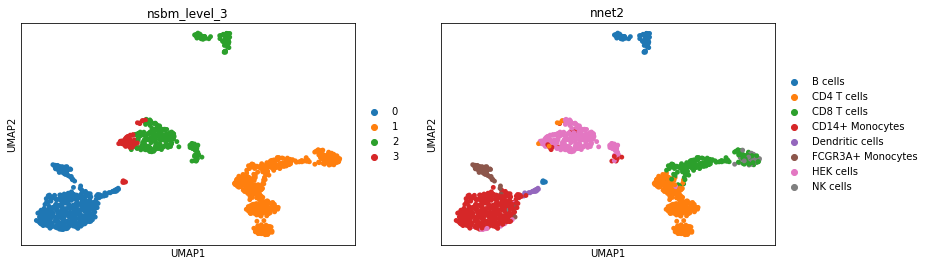

In [17]:
sc.pl.umap(adatam3,color=['nsbm_level_3','nnet2'])

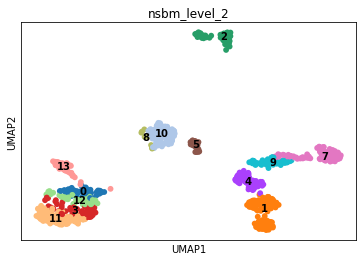

In [21]:
sc.pl.umap(ciao3,color='nsbm_level_2',legend_loc='on data')

# Linear Weighted Model

In [19]:
adata=adatam.copy()

In [33]:
marginals = adata.uns['nsbm']['cell_affinity']['2'] 
groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) 
expr_values = adata.X
weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
weight_results = [x.fit() for x in weight_model]


weight_scores = np.array([x.params[1:] for x in weight_results])
weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
for x in range(weight_scores.shape[1]):
    up_mask = weight_scores[:, x] > 0
    scores = weight_scores[up_mask, x]
    pvals = weight_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = weight_fdr[up_mask, x]
    selected = np.argsort(fdr)[:100]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])

In [34]:
e=dict()
e['n_cells']=e.get('n_cells',len(adata.obs.index))
for i in range(len(adata.obs.nsbm_level_2.cat.categories)):
    e[adata.obs.nsbm_level_2.cat.categories[i]]=e.get(adata.obs.nsbm_level_2.cat.categories[i],{})
    count=0
    for s in adata.obs.nsbm_level_2:
        if s==adata.obs.nsbm_level_2.cat.categories[i]:
            count=count+1
    e[adata.obs.nsbm_level_2.cat.categories[i]]['n_obs']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('n_obs', count)
    sel_p=[]
    sel_g=[]
    for x in range(len(gene_fdr[i])):
        if gene_fdr[i][x]<0.05:
            sel_p.append(gene_fdr[int(i)][x])
            sel_g.append(gene_names[int(i)][x])
    e[adata.obs.nsbm_level_2.cat.categories[i]]['n_significative']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('n_significative', len(sel_g))
    e[adata.obs.nsbm_level_2.cat.categories[i]]['gene_names']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('gene_names', sel_g)
    e[adata.obs.nsbm_level_2.cat.categories[i]]['pvals_adj']=e[adata.obs.nsbm_level_2.cat.categories[i]].get('pvals_adj', sel_p)
e

{'n_cells': 1266,
 '0': {'n_obs': 39,
  'n_significative': 100,
  'gene_names': ['CLEC10A',
   'PID1',
   'CMAHP',
   'RTN1',
   'CPVL',
   'FPR3',
   'CSF1R',
   'CD1D',
   'AC009093.8',
   'HLA-DPA1',
   'GGTA1P',
   'LGALS2',
   'HLA-DRB1',
   'FGL2',
   'HLA-DPB1',
   'CST3',
   'AL645941.2',
   'HLA-DMB',
   'IGSF6',
   'HLA-DRB6',
   'HLA-DRA',
   'AC007192.1',
   'CD86',
   'FGD2',
   'CHN2',
   'AIF1',
   'MS4A6A',
   'LILRA1',
   'SLC7A7',
   'ACER3',
   'SIGLEC5',
   'SERPINA1',
   'DUSP6',
   'SLC8A1',
   'FCN1',
   'SECTM1',
   'CD93',
   'AC016876.3',
   'SCLT1',
   'CSTA',
   'EMILIN2',
   'TNFSF13B',
   'KCTD12',
   'FCGRT',
   'CEBPD',
   'CD300E',
   'SPI1',
   'HLA-DQB1',
   'LGALS3',
   'TNFSF12-TNFSF13',
   'ITGAX',
   'PLXDC2',
   'MCTP1',
   'CYRIA',
   'LRRC25',
   'LST1',
   'PSAP',
   'SCO2',
   'LRP1',
   'CD33',
   'CTSS',
   'CPPED1',
   'MNDA',
   'SULF2',
   'LRMDA',
   'CTSB',
   'GRN',
   'MPEG1',
   'TBXAS1',
   'JAML',
   'TIMP2',
   'FCER1G',
   'TNFA

In [16]:
pickle.dump(e,open('cell_affinity_significance/minimize_linear_weighted_adatam_Quartzseq.pkl','wb'),2)

In [12]:
pickle.dump(e,open('cell_affinity_significance/equilibrate_linear_weighted_adatae_Quartzseq.pkl','wb'),2)

In [11]:
equilibrate_linear_weighted=pickle.load(open('cell_affinity_significance/equilibrate_linear_weighted_adatae_Quartzseq.pkl','rb'))
minimize_linear_weighted=pickle.load(open('cell_affinity_significance/minimize_linear_weighted_adatam_Quartzseq.pkl','rb'))

# ---------

In [3]:
equilibrate_linear_weighted=pickle.load(open('cell_affinity_significance/equilibrate_linear_weighted_adatae_Quartzseq.pkl','rb'))
minimize_linear_weighted=pickle.load(open('cell_affinity_significance/minimize_linear_weighted_adatam_Quartzseq.pkl','rb'))
equilibrate_linear_flat=pickle.load(open('cell_affinity_significance/equilibrate_linear_flat_adatae_Quartzseq.pkl','rb'))
minimize_linear_flat=pickle.load(open('cell_affinity_significance/minimize_linear_flat_adatam_Quartzseq.pkl','rb'))

In [71]:
dato=minimize_linear_flat

indici=[]
for x,r in dato['e0'].items():
    indici.append(x)
colonne=[x for x in dato]

fraz_cell_tot=[round(dato[x]['n_cells']/dato['e0']['n_cells']*100,2) for x in dato]

df_linear_flat_fraz=pd.DataFrame(index=indici, columns=colonne)
df_linear_flat_fraz.shape

(16, 12)

In [72]:
for x in dato:
    for gruppo in dato[x]:
        try:
            df_linear_flat_fraz.loc[gruppo,x]=round(dato[x][gruppo]['n_obs']/dato['e0'][gruppo]['n_obs']*100,2)
        except TypeError:
            continue
    for d in range(len(fraz_cell_tot)):
        df_linear_flat_fraz.iloc[0,d]=fraz_cell_tot[d]
    

In [73]:
df_linear_flat_fraz.to_csv('cell_affinity_significance/fraz_cell_adatam3_Quartzseq.csv')

In [70]:
df_linear_flat_fraz.to_csv('cell_affinity_significance/fraz_cell_adatae3_Quartzseq.csv')

In [4]:
df_min=pd.read_csv('cell_affinity_significance/fraz_cell_adatam3_Quartzseq.csv',index_col=0)
df_eq=pd.read_csv('cell_affinity_significance/fraz_cell_adatae3_Quartzseq.csv',index_col=0)

In [5]:
df_eq

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10
n_cells,100.0,90.76,78.28,64.38,50.08,39.42,29.07,20.54,14.22,8.29,6.24
0,100.0,100.00,100.00,92.11,81.58,73.68,63.16,44.74,34.21,26.32,18.42
1,100.0,93.75,78.12,71.88,59.38,40.62,31.25,18.75,9.38,3.12,NaN
2,100.0,90.91,85.45,70.91,50.91,40.00,29.09,25.45,23.64,14.55,12.73
3,100.0,93.07,77.23,65.35,50.50,36.63,24.75,11.88,4.95,1.98,0.99
4,100.0,95.59,91.18,85.29,83.82,77.94,66.18,60.29,51.47,22.06,14.71
5,100.0,46.67,40.00,33.33,20.00,13.33,6.67,6.67,NaN,NaN,NaN
6,100.0,89.84,78.91,61.72,43.75,32.03,21.88,11.72,5.47,3.12,NaN
7,100.0,94.51,84.62,73.63,59.89,50.00,41.76,31.87,22.53,13.74,10.44
8,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


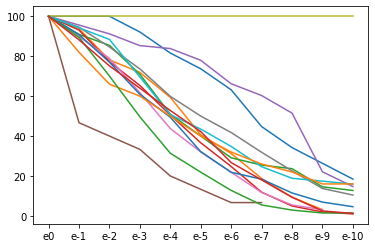

In [6]:
for i in range(1,len(df_eq.index)):
    plot(df_eq.iloc[i,:])

In [6]:
categ=[]
for x,y in equilibrate_linear_flat.items():
    categ.append(str(x))
N_CELL=[]
N_SIGN=[]
for group in range(len(equilibrate_linear_flat['e0'])-1):
    N_OBS=[]
    N_OBS_SIG=[]
    for significance in categ:
        try:
            N_OBS.append(equilibrate_linear_flat[significance][str(group)]['n_obs'])
            N_OBS_SIG.append(equilibrate_linear_flat[significance][str(group)]['n_significative'])
        except KeyError:
            N_OBS.append(0)
            N_OBS_SIG.append(0)
    N_SIGN.append(N_OBS_SIG)
    N_CELL.append(N_OBS)

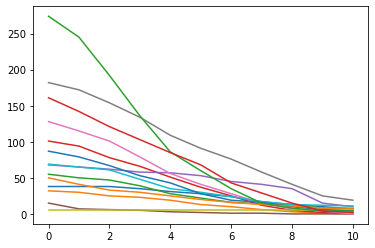

In [7]:
for i in N_CELL:
    plot(i)

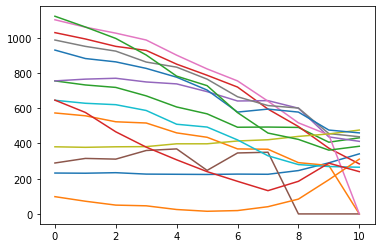

In [8]:
for i in N_SIGN:
    plot(i)
    #pyplot.yscale('log')

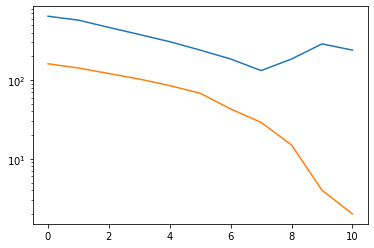

In [65]:
e=13
plot(N_SIGN[e])
plot(N_CELL[e])
pyplot.yscale('log')

In [37]:
for i in equilibrate_linear_flat['e-7']['11']['gene_names']:
    print(i)

TXNIP
HLA-A
NAP1L2
BCL11B
CHRNA10
LEF1
ETS1
MAL
AL807752.1
AC012464.1
MEOX1
AL031599.1
CTLA4
LMNTD1
AL662907.2
CCR12P
AC103563.7
CD248
MYH16
AL139415.1
AC105031.2
AC134407.1
LINC01644
AC025884.1
ATOH8
LMNTD2
DIRC3-AS1
SIRPB3P
CERS3
GTSCR1
LINC00092
AC138819.1
ACTN1-AS1
ESPN
TRAV41
AC245297.2
CACNA1F
ST6GALNAC1
GULOP
SEC14L4
MAPT-AS1


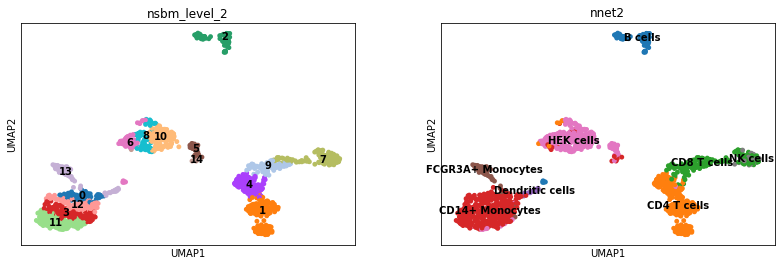

In [79]:
sc.pl.umap(adatam3,color=['nsbm_level_2','nnet2'],legend_loc='on data')

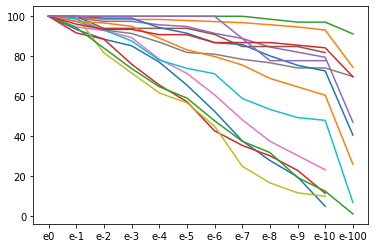

In [4]:
for i in range(1,len(df_min.index)):
    plot(df_min.iloc[i,:])

In [77]:
df_min

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100.0,97.47,93.84,90.76,85.78,81.99,76.78,71.33,66.90,62.72,58.93,37.20
0,100.0,93.44,88.52,85.25,77.05,65.57,52.46,37.70,27.87,19.67,4.92,NaN
1,100.0,99.47,98.40,98.40,98.40,97.87,97.34,96.81,95.74,94.68,93.09,74.47
2,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.53,97.06,97.06,91.18
3,100.0,91.67,88.54,76.04,65.62,57.29,42.71,35.42,30.21,22.92,11.46,NaN
4,100.0,99.15,97.44,97.44,95.73,94.87,91.45,88.89,84.62,82.05,79.49,47.01
5,100.0,100.00,93.94,93.94,93.94,93.94,90.91,84.85,84.85,84.85,81.82,NaN
6,100.0,94.64,92.86,89.29,78.57,71.43,60.71,48.21,37.50,30.36,23.21,NaN
7,100.0,97.41,93.10,91.38,87.07,81.90,81.03,78.45,76.72,74.14,74.14,69.83
8,100.0,100.00,81.67,71.67,61.67,56.67,45.00,25.00,16.67,11.67,10.00,NaN


In [5]:
categ=[]
for x,y in minimize_linear_flat.items():
    categ.append(str(x))
N_CELL=[]
N_SIGN=[]
for group in range(len(minimize_linear_flat['e0'])-1):
    N_OBS=[]
    N_OBS_SIG=[]
    for significance in categ:
        try:
            N_OBS.append(minimize_linear_flat[significance][str(group)]['n_obs'])
            N_OBS_SIG.append(minimize_linear_flat[significance][str(group)]['n_significative'])
        except KeyError:
            N_OBS.append(0)
            N_OBS_SIG.append(0)
    N_SIGN.append(N_OBS_SIG)
    N_CELL.append(N_OBS)

[827, 818, 815, 813, 785, 744, 712, 629, 544, 465, 261, 0]
[1067, 1056, 1042, 1042, 1032, 1023, 1002, 934, 924, 888, 785, 436]
[793, 786, 790, 782, 785, 782, 768, 754, 751, 735, 692, 555]
[1040, 1038, 1035, 1017, 964, 953, 855, 815, 768, 713, 573, 0]
[856, 854, 847, 841, 820, 801, 773, 739, 718, 702, 646, 370]
[226, 226, 223, 219, 219, 218, 221, 222, 221, 219, 209, 0]
[145, 139, 135, 136, 142, 146, 151, 156, 187, 224, 253, 0]
[923, 905, 912, 899, 870, 858, 846, 819, 803, 778, 743, 565]
[1, 0, 4, 7, 8, 2, 6, 13, 20, 27, 27, 0]
[712, 722, 727, 701, 669, 662, 641, 580, 553, 519, 494, 207]
[899, 904, 909, 908, 895, 888, 897, 864, 848, 822, 777, 391]
[1166, 1156, 1156, 1145, 1135, 1103, 1108, 1083, 1055, 1026, 989, 813]
[998, 991, 969, 936, 910, 882, 833, 762, 721, 584, 503, 196]
[697, 691, 685, 684, 676, 677, 664, 661, 670, 668, 649, 620]
[118, 117, 119, 116, 113, 111, 112, 105, 64, 61, 64, 0]


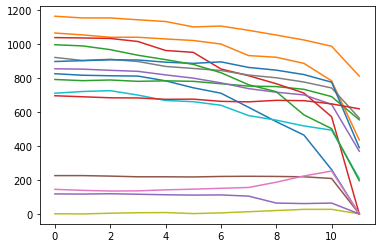

In [16]:
for i in N_SIGN:
    print(i)
    plot(i)

[61, 57, 54, 52, 47, 40, 32, 23, 17, 12, 3, 0]
[188, 187, 185, 185, 185, 184, 183, 182, 180, 178, 175, 140]
[68, 68, 68, 68, 68, 68, 68, 68, 67, 66, 66, 62]
[96, 88, 85, 73, 63, 55, 41, 34, 29, 22, 11, 0]
[117, 116, 114, 114, 112, 111, 107, 104, 99, 96, 93, 55]
[33, 33, 31, 31, 31, 31, 30, 28, 28, 28, 27, 0]
[56, 53, 52, 50, 44, 40, 34, 27, 21, 17, 13, 0]
[116, 113, 108, 106, 101, 95, 94, 91, 89, 86, 86, 81]
[60, 60, 49, 43, 37, 34, 27, 15, 10, 7, 6, 0]
[73, 72, 68, 64, 57, 54, 52, 43, 39, 36, 35, 5]
[106, 106, 105, 105, 100, 97, 92, 91, 85, 80, 77, 43]
[119, 116, 115, 113, 106, 99, 95, 90, 82, 77, 72, 31]
[88, 83, 74, 65, 57, 52, 42, 33, 28, 17, 11, 1]
[76, 73, 71, 71, 69, 69, 66, 66, 66, 65, 64, 53]
[9, 9, 9, 9, 9, 9, 9, 8, 7, 7, 7, 0]


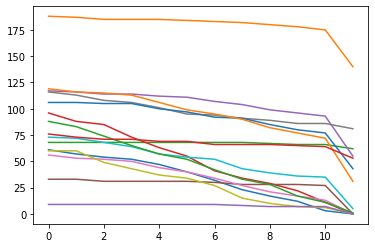

In [15]:
for i in N_CELL:
    print(i)
    plot(i)

In [9]:
categ=['e0','e-1','e-2','e-3','e-4','e-5','e-6','e-7','e-8','e-9','e-10','e-100']
resol=[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-100]

In [10]:
flat_model=dict()
for res in range(len(resol)):
    M=adatam3.uns['nsbm']['cell_affinity']['3']
    adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
    ciao3=adatam3[adatam3.obs.max_u < resol[res]]
    adata=ciao3.copy()
    e=dict()
    e['n_cells']=e.get('n_cells',len(adata.obs.index))
    for i in range(len(adata.obs.nsbm_level_3.cat.categories)):
        e[adata.obs.nsbm_level_3.cat.categories[i]]=e.get(adata.obs.nsbm_level_3.cat.categories[i],{})
        count=0
        for s in adata.obs.nsbm_level_3:
            if s==adata.obs.nsbm_level_3.cat.categories[i]:
                count=count+1
        e[adata.obs.nsbm_level_3.cat.categories[i]]['n_obs']=e[adata.obs.nsbm_level_3.cat.categories[i]].get('n_obs', count)
    flat_model[categ[res]]=flat_model.get(categ[res],e)

In [11]:
dato=flat_model

indici=[]
for x,r in dato['e0'].items():
    indici.append(x)
colonne=[x for x in dato]

fraz_cell_tot=[round(dato[x]['n_cells']/dato['e0']['n_cells']*100,2) for x in dato]

df_linear_flat_fraz=pd.DataFrame(index=indici, columns=colonne)
df_linear_flat_fraz.shape

(5, 12)

In [12]:
for x in dato:
    for gruppo in dato[x]:
        try:
            df_linear_flat_fraz.loc[gruppo,x]=round(dato[x][gruppo]['n_obs']/dato['e0'][gruppo]['n_obs']*100,2)
        except TypeError:
            continue
    for d in range(len(fraz_cell_tot)):
        df_linear_flat_fraz.iloc[0,d]=fraz_cell_tot[d]
    

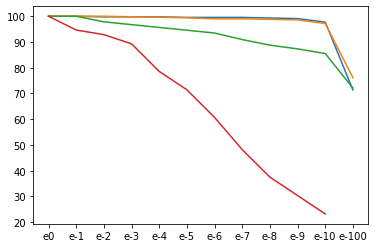

In [13]:
for i in range(1,len(df_linear_flat_fraz.index)):
    plot(df_linear_flat_fraz.iloc[i,:])

In [14]:
df_linear_flat_fraz

,e0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,e-9,e-10,e-100
n_cells,100,99.76,99.13,98.66,97.87,97.16,96.29,95.18,94.08,93.29,91.55,70.22
0,100,100,99.77,99.77,99.77,99.55,99.55,99.55,99.32,99.09,97.73,71.36
1,100,100,100,99.8,99.6,99.39,98.99,98.99,98.79,98.58,97.17,76.11
2,100,100,97.83,96.74,95.65,94.57,93.48,90.94,88.77,87.32,85.51,72.1
3,100,94.64,92.86,89.29,78.57,71.43,60.71,48.21,37.5,30.36,23.21,NaN


In [15]:
M=adatam3.uns['nsbm']['cell_affinity']['3']
adatam3.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatam3[adatam3.obs.max_u < 1e-100]

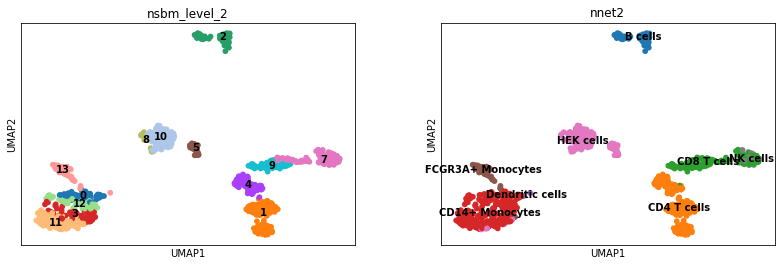

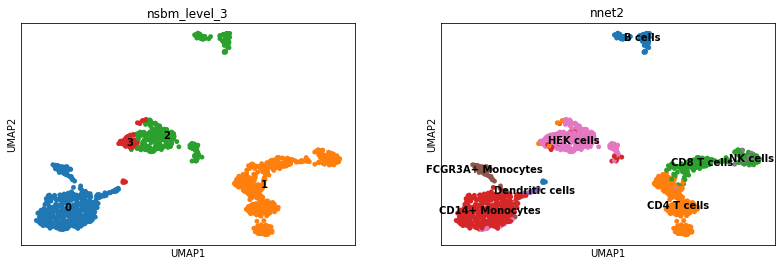

In [17]:
sc.pl.umap(ciao3,color=['nsbm_level_2','nnet2'], legend_loc='on data')
sc.pl.umap(adatam3,color=['nsbm_level_3','nnet2'], legend_loc='on data')

In [4]:
gene_sig=[]
for g in adatam.obs.nsbm_level_2.cat.categories:
    level=str(g)
    count=0
    for i in minimize_linear_flat['e0'][level]['gene_names'][:100]: 
        for j in minimize_linear_weighted[level]['gene_names']:
            if i==j:
                count=count+1
    count=count/len(minimize_linear_flat['e0'][level]['gene_names'][:100])
    gene_sig.append(count)
print(gene_sig)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 0.77, 1.0]


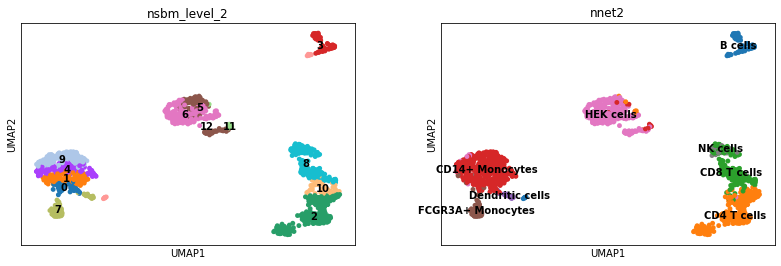

In [7]:
sc.pl.umap(adatam, color=['nsbm_level_2','nnet2'],legend_loc='on data')

In [5]:
gene_sig=[]
for g in adatae.obs.nsbm_level_2.cat.categories:
    level=str(g)
    count=0
    for i in equilibrate_linear_flat['e0'][level]['gene_names'][:100]: 
        for j in equilibrate_linear_weighted[level]['gene_names'][:100]:
            if i==j:
                count=count+1
    count=count/len(equilibrate_linear_flat['e0'][level]['gene_names'][:100])
    gene_sig.append(count)
print(gene_sig)

[0.33, 0.11, 0.0, 0.02, 0.04, 0.02, 0.15, 0.1, 0.01, 0.13, 0.02, 0.16]


In [56]:
e

{'n_cells': 1266,
 '0': {'n_obs': 76,
  'n_significative': 5,
  'gene_names': ['ZNF20', 'ADTRP', 'AC105749.1', 'SSH3', 'RNA5SP207'],
  'pvals_adj': [0.0030337109220118295,
   0.02774567812446592,
   0.018538737042297467,
   0.041689124319899754,
   0.041689124319899754]},
 '1': {'n_obs': 60}}

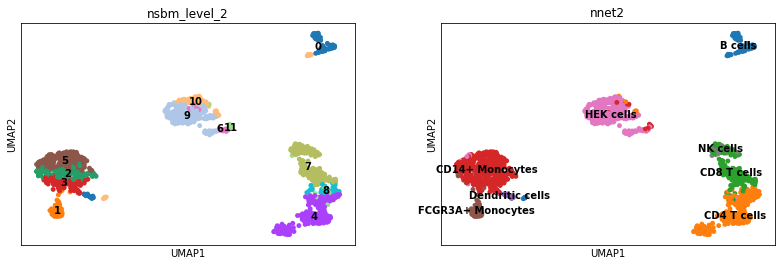

In [7]:
sc.pl.umap(adatae, color=['nsbm_level_2','nnet2'],legend_loc='on data')

In [22]:
for i in equilibrate_linear_weighted['4']['gene_names'][:100]:
    print(i)

LINC01857
ARHGAP24
LOC101927531
CSGALNACT1
FCRL2
IGHM
PLEKHG1
ACSM3
RALGPS2
NCF1C
PAX5
VNN2
MS4A1
LINC00494
OSBPL10
CPED1
EBF1
SELL
LINC00926
FCRLA
TNFRSF13B
NIBAN3
BACH2
CD22
BANK1
P2RX5-TAX1BP3
CD79A
BMP2K
BLNK
CNR2
ENSG00000168078.9
TPCN1
TNFRSF13C
CD79B
CR1
TBC1D9
BLK
AC020909.1
ST6GALNAC3
CD19
IGLC3
PCSK5
MAN1C1
POU2AF1
CLMN
SIGLEC1
AL078459.1
VPREB3
PIGZ
RUBCNL
FAM30A
HMMR
KLHL14
ALOX5
SLC16A5
AL355987.1
SOCS5
CENPF
IGHD
AC063949.2
CREB5
AFF3
ACTN1
LRRK2
IL6ST
STAP1
ANKRD55
UBE2E2
ZNF441
SESN3
FCRL1
MARCHF1
KMO
CCR7
IGF1R
AL355076.2
RELL1
PKIG
HIF1A
IGHG1
PLK1
IRS2
OSBPL1A
IFNGR2
ZNF467
TBC1D27P
KIF13A
BIRC5
CD40
DENND5B
CDK14
TNS3
SLC22A15
BTLA
CNKSR2
CD24
PADI4
ATG9B
AC096733.3
SWAP70


In [20]:
for i in equilibrate_linear_flat['e0']['2']['gene_names'][:100]:print(i)

CD14
VCAN
CSF3R
MS4A6A
LRP1
TNFAIP2
FCN1
S100A8
PTAFR
CPVL
S100A9
MNDA
CD36
KIF13A
S100A12
PLXDC2
LYZ
NCF2
TFEC
CLEC7A
DMXL2
RBM47
CREB5
STAB1
RNF130
GAS7
IRAK3
CD163L1
FOS
TGFBI
CPPED1
NFAM1
ALDH2
ZNF467
CEBPD
CTSS
LINC00937
LRMDA
ARHGEF10L
CLEC12A
GRN
IL17RA
TBXAS1
AF241726.2
GLT1D1
LGALS2
SCO2
SIRPA
FPR1
PRAM1
FCGR2A
NUMB
VMP1
CLEC4E
SIRPB2
RIN2
CLMN
BACH1
FGR
MEGF9
SULF2
ALOX5
EVI5
TIMP2
AC007192.1
JAML
RASSF4
HCK
GCA
CD300E
PTPRE
CSTA
SLC11A1
MCTP1
FGL2
RAB31
HNMT
TLR2
SCPEP1
TYMP
F13A1
SLC8A1
SPI1
PID1
FGD4
RGS2
MICAL2
AL160272.2
TNFSF13B
MPEG1
NOD2
LOC105373780
ARHGAP26
PSAP
PLBD1
PRKCD
DUSP6
BST1
MAML3
ZSWIM6


In [51]:
M=adatae.uns['nsbm']['cell_affinity']['3']
adatae.obs['max_u'] = 1 - np.max(M, axis=1)
ciao3=adatae[adatae.obs.max_u < 1e-5]

Trying to set attribute `.uns` of view, copying.


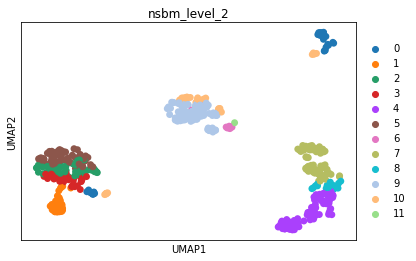

In [52]:
sc.pl.umap(ciao3,color='nsbm_level_2')

In [43]:
marginals=adatae.obs['max_u']

In [8]:
Marginals=adatam.uns['nsbm']['cell_affinity']['2']-(1/13)

In [ ]:
OldRange = (100 - 0)  
NewRange = (100 - c)  
NewValue = (((100 - 0) * NewRange) / OldRange) + c

In [30]:
marg=[]
marginal=[]
for i in range(len(Marginals)):
    marg=[]
    for j in range(len(Marginals[i])):
        NewValue = (((Marginals[i][j] - 0) * (100 - c)) / (100 - 0)) + c
        marg.append(NewValue)
    marginal.append(marg)

In [31]:
c=1/13

In [32]:
marginal

[[0.9992899408213425,
  5.917160469316729e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05],
 [6.593689650465084e-05,
  0.9992831755295304,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.917159763356439e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05],
 [5.9171597633134176e-05,
  5.9171597633134176e-05,
  0.9992899408284024,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05,
  5.9171597633134176e-05]

In [6]:
len(adatam.uns['nsbm']['cell_affinity']['2'][0])


13

In [4]:
pd.crosstab(adatam.obs['nsbm_level_2'],adatam.obs['nnet2'])

nnet2,B cells,CD4 T cells,CD8 T cells,CD14+ Monocytes,Dendritic cells,FCGR3A+ Monocytes,HEK cells,NK cells
nsbm_level_2,,,,,,,,
0,0,0,0,32,2,5,0,0
1,0,0,0,100,0,2,1,1
2,0,272,4,0,0,0,1,0
3,62,0,0,0,0,0,0,0
4,0,0,0,96,0,2,1,0
5,0,2,0,6,0,0,74,0
6,0,3,0,4,0,0,159,0
7,0,0,0,0,16,55,0,0
8,0,0,140,0,0,0,0,33


In [9]:
bcell='''INPP4B
LEF1
CAMK4
SERINC5
PRKCA
TSHZ2
BCL11B
MAML2
IL7R
NELL2
ITK
LTB
TCF7
PDE3B
MLLT3
ANK3
RCAN3
BCL2
RP11-5N23.2
THEMIS
PLCL1
NDFIP1
FYB1
PCED1B
TXK
LEPROTL1
RPL21
DOCK10
NOG
AC005062.3
FOXP1
AC092155.1
TRAC
RPS6
SARAF
RP11-493L12.2
TGFBR2
FAM102A
MGAT4A
RP11-622O11.2
CSGALNACT1
RPS12
RPS25
RPS27
TRBC2
RPL34
ARHGAP15
RP11-761N21.2
TNFAIP8
RPS29
CD3D
CD3E
CTD-2287O16.1
CD3G
GAS5
ZNF331
RP11-543P15.1
CCND3
TESPA1
MAL
CD6
RPL9
RPL3
RPS3A
CCR7
ICOS
ETS1
RPS27A
C12orf79
RPL31
RPS15A
RPL13
AL162151.1
RPS13
SCML4
PITPNC1
TPT1
RPL32
C14orf64
RPL13P12
CYTH1
RP11-864N7.2
RPL7
RPS14
SKAP1
RPL7P23p
RPS20
EEF1A1P5
RPS26
RPL13A
RPS26P31
RP4-706A16.3
EEF1B2
RPL10A
RP11-592N21.1
RPL11
RPLP2
STEAP1B
RPL17-C18orf32
EEF1G
'''
bcell=bcell.split()

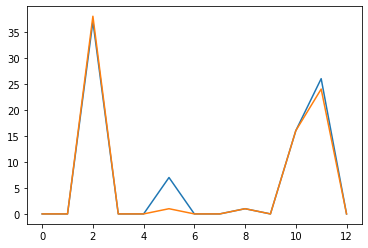

In [21]:
weight=0
wm=[]
fm=[]
flat=0
#group=str(16)
for i in adatam.obs['nsbm_level_2'].cat.categories:
    for j in minimize_linear_flat['e0'][i]['gene_names'][:100]:
        if j in bcell:
            flat=flat+1
    fm.append(flat)
    flat=0
#    for s in minimize_linear_weighted[i]['gene_names'][:100]:
    for s in minimize_linear_flat['e-5'][i]['gene_names'][:100]:
        weigth=0
        if s in bcell:
            weight=weight+1
    wm.append(weight)
    weight=0
#print('flat',flat)
#print('weight',weight)
plot(fm)
plot(wm)

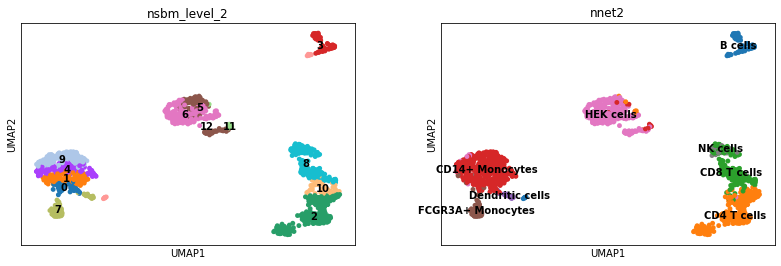

In [8]:
sc.pl.umap(adatam, color=['nsbm_level_2','nnet2'],legend_loc='on data')

# matrix with pvals

In [6]:
adata=adatam

### flat model

In [28]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
    flat_results = [x.fit() for x in flat_model]
    flat_scores = np.array([x.params[1:] for x in flat_results])
    flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
    flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T
    pickle.dump(flat_pvals,open(f'cell_affinity_significance/Quartzseq_flat_level_{level}_pvals.pkl','wb'),2)
    pickle.dump(flat_fdr,open(f'cell_affinity_significance/Quartzseq_flat_level_{level}_pvals_adj.pkl','wb'),2)

In [49]:
f_pvals_l1=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_1_pvals.pkl','rb'))
f_padj_l1=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_1_pvals_adj.pkl','rb'))
f_pvals_l2=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_2_pvals.pkl','rb'))
f_padj_l2=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_2_pvals_adj.pkl','rb'))
f_pvals_l3=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_3_pvals.pkl','rb'))
f_padj_l3=pickle.load(open('cell_affinity_significance/Quartzseq_flat_level_3_pvals_adj.pkl','rb'))

(array([2275.,  390.,  294.,  294.,  226.,  206.,  197.,  186.,  165.,
         142.,  139.,  135.,  139.,  132.,  146.,  118.,  141.,  129.,
         113.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

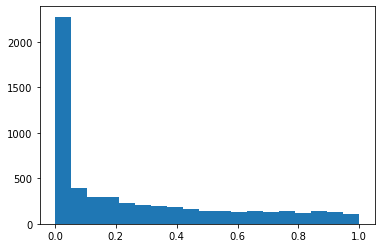

In [59]:
hist(f_pvals_l2[:,4],bins=np.linspace(0,1,20))

### weighted model

In [46]:
for level in range(1,4):
    marginals = adata.uns['nsbm']['cell_affinity'][str(level)] 
    groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{level}', drop=True) 
    expr_values = adata.X
    weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
    weight_results = [x.fit() for x in weight_model]
    weight_scores = np.array([x.params[1:] for x in weight_results])
    weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
    weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T
    pickle.dump(weight_pvals,open(f'cell_affinity_significance/Quartzseq_weighted_level_{level}_pvals.pkl','wb'),2)
    pickle.dump(weight_fdr,open(f'cell_affinity_significance/Quartzseq_weighted_level_{level}_pvals_adj.pkl','wb'),2)

ValueError: Column 'nsbm_level_0' not found in data

In [48]:

marginals = adata.uns['nsbm']['cell_affinity']['2'] 
groups = sm.tools.categorical(data = adata.obs, col=f'nsbm_level_{2}', drop=True) 
expr_values = adata.X
weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginal)) for x in range(expr_values.shape[1])]
weight_results = [x.fit() for x in weight_model]
weight_scores = np.array([x.params[1:] for x in weight_results])
weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T

In [61]:
w_pvals_l1=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_1_pvals.pkl','rb'))
w_padj_l1=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_1_pvals_adj.pkl','rb'))
w_pvals_l2=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_2_pvals.pkl','rb'))
w_padj_l2=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_2_pvals_adj.pkl','rb'))
w_pvals_l3=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_3_pvals.pkl','rb'))
w_padj_l3=pickle.load(open('cell_affinity_significance/Quartzseq_weighted_level_3_pvals_adj.pkl','rb'))

(array([1699.,  326.,  351.,  266.,  288.,  252.,  247.,  231.,  205.,
         205.,  199.,  147.,  185.,  153.,  160.,  182.,  153.,  157.,
         161.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

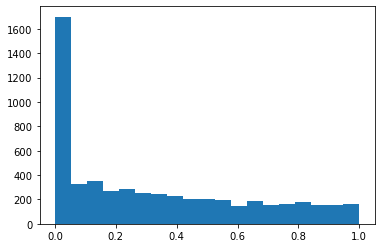

In [76]:
hist(weight_pvals[:,7],bins=np.linspace(0,1,20))

(array([1701.,  326.,  348.,  268.,  286.,  251.,  250.,  228.,  207.,
         206.,  198.,  147.,  185.,  153.,  159.,  184.,  151.,  158.,
         161.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

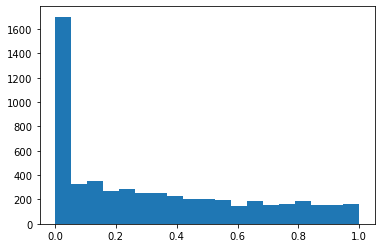

In [75]:
hist(w_pvals_l2[:,7],bins=np.linspace(0,1,20))

### scanpy

In [24]:
sc.tl.rank_genes_groups(adatam,groupby='nsbm_level_2',n_genes=-1)

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


(array([1009.,  331.,  302.,  312.,  285.,  298.,  333.,  349.,  342.,
         237.,  214.,  185.,  198.,  178.,  193.,  204.,  196.,  205.,
         195.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

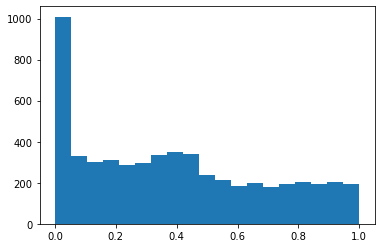

In [33]:
hist([adatam.uns['rank_genes_groups']['pvals'][x][0] for x in range(5566)],bins=np.linspace(0,1,20))